# Chapter 7 - Moving Beyond Linearity

- [Lab: 7.8.1 Polynomial Regression and Step Functions](#7.8.1-Polynomial-Regression-and-Step-Functions)
- [Lab: 7.8.2 Splines](#7.8.2-Splines)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

%matplotlib inline
plt.style.use('seaborn-white')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load dataset
Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file.

In [2]:
df = pd.read_csv('Data/Wage.csv')
df.head(3)

FileNotFoundError: File b'Data/Wage.csv' does not exist

In [ ]:
df.info()

## Lab

### 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'. These correspond to those in R, when using raw=TRUE in poly() function.

In [ ]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).values
print('X4:\n', X4[:5])
print('y:\n', y[:5])

#### Linear regression model. (Degree 4)

In [ ]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

Selecting a suitable degree for the polynomial of age.

In [ ]:
fit_1 =  sm.GLS(df.wage, X1).fit()
fit_2 =  sm.GLS(df.wage, X2).fit()
fit_3 =  sm.GLS(df.wage, X3).fit()
fit_4 =  sm.GLS(df.wage, X4).fit()
fit_5 =  sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

The polynomial degree 4 seems best.

In [ ]:
X = X4

Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [ ]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

Create array of test data. Transform to polynomial degree 4 and run prediction.

In [ ]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In [ ]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

### Figure 7.1

In [ ]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

#### Step function

In [ ]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

In [ ]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

In [ ]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(5)

In [ ]:
# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
fit3.summary().tables[1]

In [ ]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

In [ ]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

#### Linear Regression

In [ ]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [ ]:
clf2 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

### Figure 7.2

In [ ]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

### 7.8.2 Splines

Using patsy to create non-linear transformations of the input data. See http://patsy.readthedocs.org/en/latest/ <BR>
I have not found functions to create smoothing splines or GAMs or do local regression.

#### Cubic splines

In [ ]:
# Specifying 3 knots
transformed_x = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit4 = sm.GLM(df.wage, transformed_x).fit()
pred4 = fit4.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit4.params

In [ ]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit5 = sm.GLM(df.wage, transformed_x2).fit()
pred5 = fit5.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit5.params

#### Natural splines

In [ ]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit6 = sm.GLM(df.wage, transformed_x3).fit()
pred6 = fit6.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
fit6.params

In [ ]:
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred4, color='b', label='Specifying three knots')
plt.plot(age_grid, pred5, color='r', label='Specifying df=6')
plt.plot(age_grid, pred6, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

## 7.6 Local Regression

### Python implementation using Numpy: bell shaped weighting function
Based on code provided by Alexandre Gramfort, SKlearn developper
https://gist.github.com/agramfort/850437

In [5]:
from math import ceil
import numpy as np
from scipy import linalg

#Defining the bell shaped kernel function - used for plotting later on
def kernel_function(xi,x0,tau= .005): 
    return np.exp( - (xi - x0)**2/(2*tau)   )

def lowess_bell_shape_kern(x, y, tau = .005):
    """lowess_bell_shape_kern(x, y, tau = .005) -> yest
    Locally weighted regression: fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The kernel function is the bell shaped function with parameter tau. Larger tau will result in a
    smoother curve. 
    """
    m = len(x)
    yest = np.zeros(m)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([np.exp(- (x - x[i])**2/(2*tau)) for i in range(m)])     
    
    #Looping through all x-points
    for i in range(m):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

### Alternative implementations using Statsmodel  

In [6]:
import statsmodels.api as sm
lowess_sm = sm.nonparametric.lowess

### Fig 7.9 -  Local regression on a noisy sine curve 

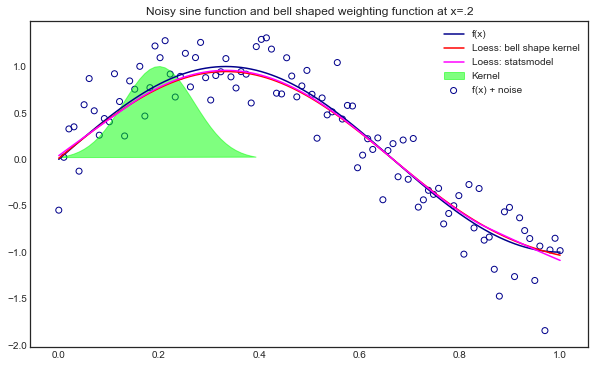

In [7]:
#Initializing noisy non linear data
x = np.linspace(0,1,100)
noise = np.random.normal(loc = 0, scale = .25, size = 100)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = y + noise
yest_bell = lowess_bell_shape_kern(x,y)
yest_sm = lowess_sm(y,x,frac=1./3.,it=3, return_sorted = False)

#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,.005), color = 'lime', alpha = .5, label = 'Kernel')

#Plot the Numpy and Statsmodel implementations
plt.plot(x,yest_bell,color = 'red', label = 'Loess: bell shape kernel')
plt.plot(x,yest_sm,color = 'magenta', label = 'Loess: statsmodel')

plt.legend()
plt.title('Noisy sine function and bell shaped weighting function at x=.2')
plt.show()

### Deriving the vectorized implementation

Consider the 1D case where $\Theta = [\theta_0, \theta_1]$ and $x$ and $y$ are vectors of size $m$. The cost function $J(\theta)$ is a weighted version of the OLS regression, where the weights $w$ are defined by some kernel function


\begin{aligned}
	J(\theta) &= \sum_{i=1}^m w^{(i)} \left( y^{(i)} - (\theta_0 + \theta_1 x^{(i)}) \right)^2
	\\
	\frac{\partial J}{\partial \theta_0} &= -2 \sum_{i=1}^m w^{(i)} \left( y^{(i)} - (\theta_0 + \theta_1 x^{(i)}) \right) 
	\\
	\frac{\partial J}{\partial \theta_1} &= -2 \sum_{i=1}^m w^{(i)} \left( y^{(i)} - (\theta_0 + \theta_1 x^{(i)}) \right) x^{(i)} 
\end{aligned}
 

Cancelling the $-2$ terms, equating to zero, expanding and re-arranging the terms: 
\begin{aligned}
	& \frac{\partial J}{\partial \theta_0} = \sum_{i=1}^m w^{(i)} \left( y^{(i)} - (\theta_0 + \theta_1 x^{(i)}) \right)  = 0
	\\
	& \sum_{i=1}^m w^{(i)}  \theta_0 + \sum_{i=1}^m w^{(i)}  \theta_1 x^{(i)}  = \sum_{i=1}^m w^{(i)} y^{(i)}  &\text{Eq. (1)}
	\\
	\\
	& \frac{\partial J}{\partial \theta_1} = \sum_{i=1}^m w^{(i)} \left( y^{(i)} - (\theta_0 + \theta_1 x^{(i)}) \right) x^{(i)}  = 0 
	\\
	& \sum_{i=1}^m w^{(i)}  \theta_0 + \sum_{i=1}^m w^{(i)}  \theta_1 x^{(i)} x^{(i)}  = \sum_{i=1}^m w^{(i)} y^{(i)}  x^{(i)} &\text{Eq. (2)}
\end{aligned}
 
Writing Eq. (1) and Eq. (2) in matrix form $\mathbf{A \Theta = b}$ allows us to solve for $\Theta$
\begin{aligned}
	& \sum_{i=1}^m w^{(i)}  \theta_0 + \sum_{i=1}^m w^{(i)}  \theta_1 x^{(i)}  = \sum_{i=1}^m w^{(i)} y^{(i)}  
	\\
	& \sum_{i=1}^m w^{(i)}  \theta_0 + \sum_{i=1}^m w^{(i)}  \theta_1 x^{(i)} x^{(i)}  = \sum_{i=1}^m w^{(i)} y^{(i)}  x^{(i)}
	\\
	& \begin{bmatrix} \sum w^{(i)} & \sum w^{(i)} x^{(i)} \\ \sum w^{(i)} x^{(i)} & \sum w^{(i)} x^{(i)} x^{(i)} \end{bmatrix}  \begin{bmatrix} \theta_0 \\ \theta_1 \end{bmatrix}   = \begin{bmatrix}  \sum w^{(i)} y^{(i)} \\  \sum w^{(i)} y^{(i)} x^{(i)} \end{bmatrix}  
	\\
	& \mathbf{A} \Theta = \mathbf{b}
	\\
	&  \Theta = \mathbf{A}^{-1} \mathbf{b}
\end{aligned}